# Airflow 콘텍스트 사용하여 태스크 템플릿 작업

- 페이지 뷰 증가는 긍정적임 감성 -> 회사 주식 증가 가능성
- 위키미디어 재단 2015년 이후의 모든 페이지 뷰 컴퓨터가 읽을 수 있는 형식으로 제공
- 페이지 뷰는 gzip 형식으로 다운로드 가능. 시간당 페이지 뷰 수 집계

## 오퍼레이터 인수 템플릿 작업

- Bashoperator 사용하여 위키피디아 페이지 뷰 다운로드
- 런타임에 자동으로 템플릿 지정

**Jinja**
- 런타임 시에 템플릿 문자열의 변수와 and 및 or 표현식을 대체하는 템플릿 엔진
- 템플릿 작성은 프로그래머로서 코드 작성 시점에는 값을 알기 어렵지만 런타임 시에 값을 할당하기 위해 사용 
- 사용자가 런타임 시에 값을 입력하기 때문에 프로그래밍할 때에는 값 알 수 없음

In [ ]:
import airflow
from airflow import DAG
from airflow.operators.bash import BashOperator

dag = DAG(
    dag_id="listing_4_01",
    start_date=airflow.utils.dates.days_ago(3),
    schedule_interval="@hourly",
)

get_data = BashOperator(
    task_id="get_data",
    bash_command=(
        "curl -o /tmp/wikipageviews.gz "
        "https://dumps.wikimedia.org/other/pageviews/"
        "{{ execution_date.year }}/" # 이중 중괄호는 런타임 시에 삽입될 변수 나타냄
        "{{ execution_date.year }}-{{ '{:02}'.format(execution_date.month) }}/"
        "pageviews-{{ execution_date.year }}"
        "{{ '{:02}'.format(execution_date.month) }}" # 빈 앞자리를 0으로 채우는 월, 일 및 시간 값이 필요 
        "{{ '{:02}'.format(execution_date.day) }}-"
        "{{ '{:02}'.format(execution_date.hour) }}0000.gz"
    ),
    dag=dag,
)

## 템플릿 사용 가능 변수

**템플릿화를 위해 사용할 수 있는 변수**
- execution_date 등
- 전체 태스크 콘텍스트 출력하여 검사하기
- conf, dag, dag_run, ds, ds_nodash, execution_date 등 

In [ ]:
import airflow.utils.dates
from airflow import DAG
from airflow.operators.python import PythonOperator

dag = DAG(
    dag_id="listing_4_03",
    start_date=airflow.utils.dates.days_ago(3),
    schedule_interval="@daily",
)


def _print_context(**kwargs):
    print(kwargs)


print_context = PythonOperator(
    task_id="print_context", python_callable=_print_context, dag=dag
)

### 성공결과

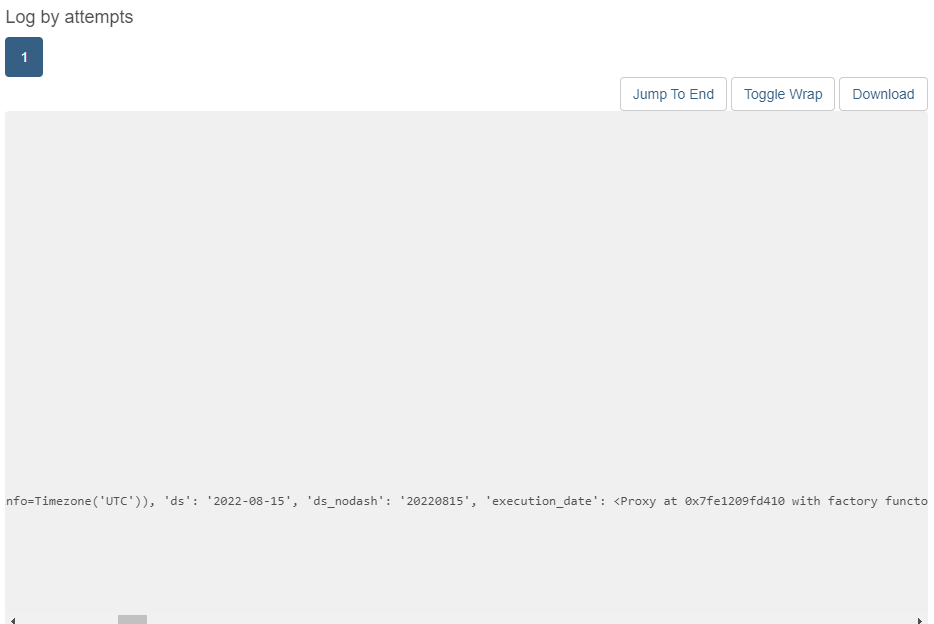

## PythonOperator 템플릿

- 런타임 콘텍스트로 템플릿화할 수 있는 인수 사용치 않고 별도로 런타임 콘텍스트 적용
- 파이썬에서 함수는 주요 요소

In [ ]:
from urllib import request

import airflow.utils.dates
from airflow import DAG
from airflow.operators.python import PythonOperator

dag = DAG(
    dag_id="listing_4_05",
    start_date=airflow.utils.dates.days_ago(1),
    schedule_interval="@hourly",
)


def _get_data(execution_date): # 태스크 컨택스트 변수
    year, month, day, hour, *_ = execution_date.timetuple() # execution_date로부터 datetime 요소 추출
    url = (
        "https://dumps.wikimedia.org/other/pageviews/"
        f"{year}/{year}-{month:0>2}/pageviews-{year}{month:0>2}{day:0>2}-{hour:0>2}0000.gz" # datetime 요소로 URL 형식화
    )
    output_path = "/tmp/wikipageviews.gz"
    request.urlretrieve(url, output_path) # 반환되는 데이터 


get_data = PythonOperator(task_id="get_data", python_callable=_get_data, dag=dag)


- 파이썬은 함수에서 키워드 인수 받을 수 있음
- 키워드 인수의 이름 지정은 Airflow 태스크 콘텍스트 변수를 확인하기 위해서 적절한 이름 사용

In [ ]:
import airflow.utils.dates
from airflow import DAG
from airflow.operators.python import PythonOperator

dag = DAG(
    dag_id="listing_4_07",
    start_date=airflow.utils.dates.days_ago(3),
    schedule_interval="@daily",
)


def _print_context(**context):
    print(context)


print_context = PythonOperator(
    task_id="print_context", python_callable=_print_context, dag=dag
)

- 콘텍스트 변수는 모든 콘텍스트 변수의 집합
- 태스크 실행 간격에 대한 다양한 동작 제공

In [ ]:
import airflow.utils.dates
from airflow import DAG
from airflow.operators.python import PythonOperator

dag = DAG(
    dag_id="listing_4_08",
    start_date=airflow.utils.dates.days_ago(3),
    schedule_interval="@daily",
)


def _print_context(**context):
    start = context["execution_date"] # context로부터 execution_date 추출
    end = context["next_execution_date"]
    print(f"Start: {start}, end: {end}")


# Prints e.g.:
# Start: 2019-07-13T14:00:00+00:00, end: 2019-07-13T15:00:00+00:00


print_context = PythonOperator(
    task_id="print_context", python_callable=_print_context, dag=dag
)

## PythonOperator에 변수 제공

- output_path를 입력 가능하게 만들어 작업에 따라 출력 경로를 변경하기 위해 전체 함수를 복사하는 대신 output_path만 별도로 구성 가능 

In [ ]:
def _get_data(output_path, **context): # 태스크 컨택스트 변수
    year, month, day, hour, *_ = execution_date.timetuple() # execution_date로부터 datetime 요소 추출
    url = (
        "https://dumps.wikimedia.org/other/pageviews/"
        f"{year}/{year}-{month:0>2}/pageviews-{year}{month:0>2}{day:0>2}-{hour:0>2}0000.gz" # datetime 요소로 URL 형식화
    )
    output_path = "/tmp/wikipageviews.gz"
    request.urlretrieve(url, output_path) # 이제 output_path를 함수 인수를 통해 구성 가능 

**output_path 값 제공**

1. op_args 인수 사용 
  - _get_data("\tmp\wikipageviews.gz") 함수 직접 호출하는 것과 동일한 결과 

In [ ]:
get_data = PythonOperator(
    task_id="get_data",
    python_callable=_get_data,
    op_args={"\tmp\wikipageviews.gz"}, # op_args를 사용하여 콜러블 함수에 추가 변수 제공 
    dag=dag, )

2. op_kwargs 인수 사용
  - _get_data(output_path='\tmp\wikipageviews.gz') 와 동등한 호출

In [ ]:
get_data = PythonOperator(
    task_id="get_data",
    python_callable=_get_data,
    op_kwargs={"output_path": "/tmp/wikipageviews.gz"}, # op.kwargs에 주어진 명령어가 호출 가능한 키워드 인수로 전달됨
    dag=dag,
)

In [ ]:
def _get_data(year, month, day, hour, output_path, **_):
    url = (
        "https://dumps.wikimedia.org/other/pageviews/"
        f"{year}/{year}-{month:0>2}/pageviews-{year}{month:0>2}{day:0>2}-{hour:0>2}0000.gz"
    )
    request.urlretrieve(url, output_path)


get_data = PythonOperator(
    task_id="get_data",
    python_callable=_get_data,
    op_kwargs={
        "year": "{{ execution_date.year }}",
        "month": "{{ execution_date.month }}",
        "day": "{{ execution_date.day }}",
        "hour": "{{ execution_date.hour }}",
        "output_path": "/tmp/wikipageviews.gz",
    },
    dag=dag,
)

## 템플릿 인수 검사

- Airflow UI에서 Rendered Template 버튼 클릭

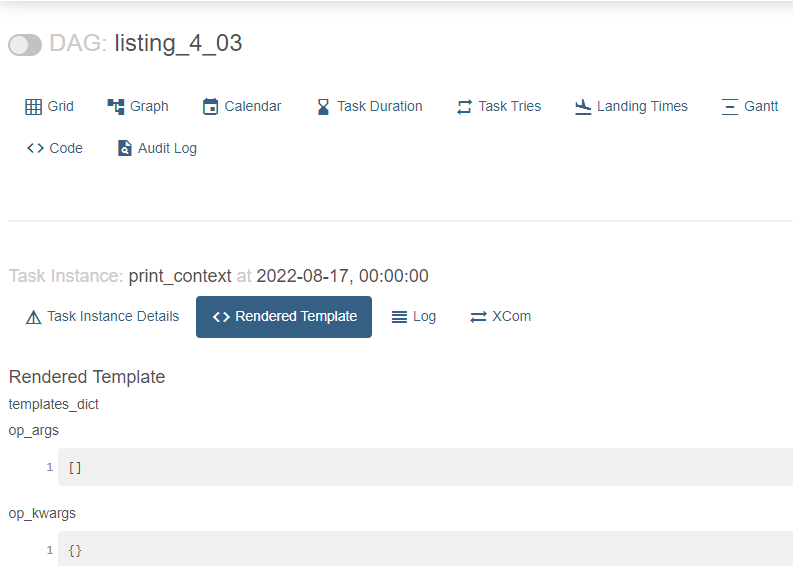

- Airflow 명령줄 인터페이스(CLI) 사용

In [ ]:
airflow tasks render [dag id] [task id] [desired execution date]

# 다른 시스템과 연결하기

- 저장소에서 추출하고 압축을 푼 파일을 스캔한 후, 지정된 페이지 이름에 대한 페이지 뷰 카운트 선택해 처리
- 결과 로그 출력

In [ ]:
from urllib import request

import airflow.utils.dates
from airflow import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator

dag = DAG(
    dag_id="listing_4_15",
    start_date=airflow.utils.dates.days_ago(1),
    schedule_interval="@hourly",
    max_active_runs=1,
)


def _get_data(year, month, day, hour, output_path, **_):
    url = (
        "https://dumps.wikimedia.org/other/pageviews/"
        f"{year}/{year}-{month:0>2}/pageviews-{year}{month:0>2}{day:0>2}-{hour:0>2}0000.gz"
    )
    request.urlretrieve(url, output_path)


get_data = PythonOperator(
    task_id="get_data",
    python_callable=_get_data,
    op_kwargs={
        "year": "{{ execution_date.year }}",
        "month": "{{ execution_date.month }}",
        "day": "{{ execution_date.day }}",
        "hour": "{{ execution_date.hour }}",
        "output_path": "/tmp/wikipageviews.gz",
    },
    dag=dag,
)

extract_gz = BashOperator(
    task_id="extract_gz", bash_command="gunzip --force /tmp/wikipageviews.gz", dag=dag
)


def _fetch_pageviews(pagenames):
    result = dict.fromkeys(pagenames, 0)
    with open("/tmp/wikipageviews", "r") as f:
        for line in f:
            domain_code, page_title, view_counts, _ = line.split(" ")
            if domain_code == "en" and page_title in pagenames:
                result[page_title] = view_counts

    print(result)
    # Prints e.g. "{'Facebook': '778', 'Apple': '20', 'Google': '451', 'Amazon': '9', 'Microsoft': '119'}"


fetch_pageviews = PythonOperator(
    task_id="fetch_pageviews",
    python_callable=_fetch_pageviews,
    op_kwargs={"pagenames": {"Google", "Amazon", "Apple", "Microsoft", "Facebook"}},
    dag=dag,
)

get_data >> extract_gz >> fetch_pageviews

- 출력 저장 위한 테이블 생성 구문
- INSERT 쿼리

In [ ]:
CREATE TABLE pageview_counts (
    pagename VARCHAR(50) NOT NULL, # 위키피디아 페이지 네임
    pageviewcount INT NOT NULL, # 주어진 시간 동안 해당 페이지의 페이지 뷰 수
    datetime TIMESTAMP NOT NULL # 페이지 뷰 수에 관련된 날짜와 시간 포함 
);

INSERT INTO pageview_counts VALUES ('Google', 333, '2019-07-17T00:00:00');

**Airflow 태스크 간 데이터 전달 방법**
1. Airflow 메타스토어를 사용하여 태스크 간 결과 쓰고 읽기. XCom
2. 영구적인 위치(디스크, 데이터베이스 등)에 태스크 결과 기록

- 태스크 간에 데이터를 저장하는 방법을 결정하기 위해서는 데이터가 다시 사용되는 위치와 방법 알아야 함
- 대상이 되는 데이터베이스가 Postgres이므로 PostgresOperator를 사용해 데이터 입력
- PostgresOperator 클래스 가져오기 위한 추가 패키지 설치
- Airflow2 이후 대부분의 오퍼레이터는 별도의 pip 패키지를 통해 설치
- PostgresOperator는 CSV 데이터로부터 입력하는 기능을 지원하지 않으므로 먼저 SQL 쿼리를 임시 데이터로 작성

In [ ]:
pip install apache-airflow-providers-postgres

In [ ]:
def _fetch_pageviews(pagenames, execution_date, **_):
    result = dict.fromkeys(pagenames, 0) # 0으로 모든 페이지 뷰에 대한 결과 초기화
    with open("/tmp/wikipageviews", "r") as f:
        for line in f:
            domain_code, page_title, view_counts, _ = line.split(" ")
            if domain_code == "en" and page_title in pagenames:
                result[page_title] = view_counts # 페이지 뷰 저장

    with open("/tmp/postgres_query.sql", "w") as f:
        for pagename, pageviewcount in result.items(): # 각 결과에 대해 SQL 쿼리 작성
            f.write(
                "INSERT INTO pageview_counts VALUES ("
                f"'{pagename}', {pageviewcount}, '{execution_date}'"
                ");\n"
            )


fetch_pageviews = PythonOperator(
    task_id="fetch_pageviews",
    python_callable=_fetch_pageviews,
    op_kwargs={"pagenames": {"Google", "Amazon", "Apple", "Microsoft", "Facebook"}},
    dag=dag,
)

In [ ]:
# """
# Documentation of pageview format: https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Pageviews
# """

from urllib import request

import airflow.utils.dates
from airflow import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator
from airflow.providers.postgres.operators.postgres import PostgresOperator

dag = DAG(
    dag_id="listing_4_20",
    start_date=airflow.utils.dates.days_ago(1),
    schedule_interval="@hourly",
    template_searchpath="/tmp", # sql 파일 탐색 경로 
    max_active_runs=1,
)


def _get_data(year, month, day, hour, output_path):
    url = (
        "https://dumps.wikimedia.org/other/pageviews/"
        f"{year}/{year}-{month:0>2}/pageviews-{year}{month:0>2}{day:0>2}-{hour:0>2}0000.gz"
    )
    request.urlretrieve(url, output_path)


get_data = PythonOperator(
    task_id="get_data",
    python_callable=_get_data,
    op_kwargs={
        "year": "{{ execution_date.year }}",
        "month": "{{ execution_date.month }}",
        "day": "{{ execution_date.day }}",
        "hour": "{{ execution_date.hour }}",
        "output_path": "/tmp/wikipageviews.gz",
    },
    dag=dag,
)


extract_gz = BashOperator(
    task_id="extract_gz", bash_command="gunzip --force /tmp/wikipageviews.gz", dag=dag
)


def _fetch_pageviews(pagenames, execution_date):
    result = dict.fromkeys(pagenames, 0)
    with open("/tmp/wikipageviews", "r") as f:
        for line in f:
            domain_code, page_title, view_counts, _ = line.split(" ")
            if domain_code == "en" and page_title in pagenames:
                result[page_title] = view_counts

    with open("/tmp/postgres_query.sql", "w") as f:
        for pagename, pageviewcount in result.items():
            f.write(
                "INSERT INTO pageview_counts VALUES ("
                f"'{pagename}', {pageviewcount}, '{execution_date}'"
                ");\n"
            )


fetch_pageviews = PythonOperator(
    task_id="fetch_pageviews",
    python_callable=_fetch_pageviews,
    op_kwargs={"pagenames": {"Google", "Amazon", "Apple", "Microsoft", "Facebook"}},
    dag=dag,
)

write_to_postgres = PostgresOperator(
    task_id="write_to_postgres",
    postgres_conn_id="my_postgres", # 연결에 사용할 인증 정보의 식별자
    sql="postgres_query.sql", # SQL 쿼리 또는 SQL 쿼리를 포함하는 파일의 경로 
    dag=dag,
)

get_data >> extract_gz >> fetch_pageviews >> write_to_postgres

- CLI 사용하여 Airflow에 자격 증명 저장

In [ ]:
airflow connections add \ 
    --conn-type postgres \ 
    --conn-host localhost \ 
    --conn-login postgres \ 
    --conn-password mysecretpassword \ 
    my_postgres # 연결 식별자

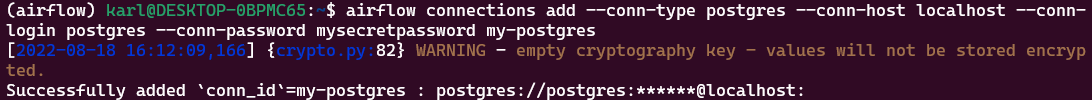

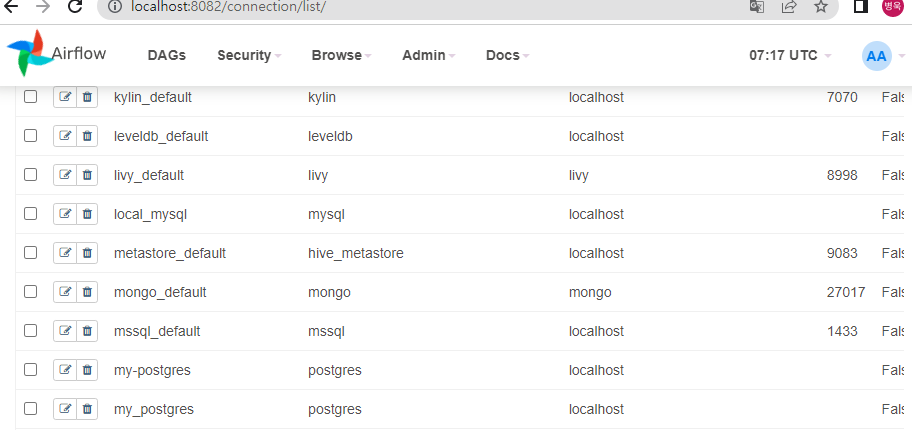

- 페이지당 가장 인기 있는 시간 확인 SQL 쿼리

In [ ]:
SELECT x.pagename, x.hr AS "hour", x.average AS "average pageviews"
FROM (
  SELECT
    pagename,
    date_part('hour', datetime) AS hr,
    AVG(pageviewcount) AS average,
    ROW_NUMBER() OVER (PARTITION BY pagename ORDER BY AVG(pageviewcount) DESC)
  FROM pageview_counts
  GROUP BY pagename, hr
) AS x
WHERE row_number=1;

# Error

In [ ]:
DESKTOP-0BPMC65.localdomain
*** Reading local file: /home/karl/airflow/logs/dag_id=listing_4_20/run_id=scheduled__2022-08-17T00:00:00+00:00/task_id=write_to_postgres/attempt=3.log
[2022-08-18 16:27:47,748] {taskinstance.py:1179} INFO - Dependencies all met for <TaskInstance: listing_4_20.write_to_postgres scheduled__2022-08-17T00:00:00+00:00 [queued]>
[2022-08-18 16:27:47,752] {taskinstance.py:1179} INFO - Dependencies all met for <TaskInstance: listing_4_20.write_to_postgres scheduled__2022-08-17T00:00:00+00:00 [queued]>
[2022-08-18 16:27:47,752] {taskinstance.py:1376} INFO - 
--------------------------------------------------------------------------------
[2022-08-18 16:27:47,752] {taskinstance.py:1377} INFO - Starting attempt 3 of 3
[2022-08-18 16:27:47,752] {taskinstance.py:1378} INFO - 
--------------------------------------------------------------------------------
[2022-08-18 16:27:47,763] {taskinstance.py:1397} INFO - Executing <Task(PostgresOperator): write_to_postgres> on 2022-08-17 00:00:00+00:00
[2022-08-18 16:27:47,764] {standard_task_runner.py:52} INFO - Started process 6672 to run task
[2022-08-18 16:27:47,766] {standard_task_runner.py:79} INFO - Running: ['airflow', 'tasks', 'run', 'listing_4_20', 'write_to_postgres', 'scheduled__2022-08-17T00:00:00+00:00', '--job-id', '106', '--raw', '--subdir', 'DAGS_FOLDER/listing_4_20.py', '--cfg-path', '/tmp/tmphilq7u07', '--error-file', '/tmp/tmpi4ppgcke']
[2022-08-18 16:27:47,767] {standard_task_runner.py:80} INFO - Job 106: Subtask write_to_postgres
[2022-08-18 16:27:47,798] {task_command.py:371} INFO - Running <TaskInstance: listing_4_20.write_to_postgres scheduled__2022-08-17T00:00:00+00:00 [running]> on host DESKTOP-0BPMC65.localdomain
[2022-08-18 16:27:47,838] {taskinstance.py:1591} INFO - Exporting the following env vars:
AIRFLOW_CTX_DAG_OWNER=airflow
AIRFLOW_CTX_DAG_ID=listing_4_20
AIRFLOW_CTX_TASK_ID=write_to_postgres
AIRFLOW_CTX_EXECUTION_DATE=2022-08-17T00:00:00+00:00
AIRFLOW_CTX_TRY_NUMBER=3
AIRFLOW_CTX_DAG_RUN_ID=scheduled__2022-08-17T00:00:00+00:00
[2022-08-18 16:27:47,842] {base.py:68} INFO - Using connection ID 'my_postgres' for task execution.
[2022-08-18 16:27:47,843] {taskinstance.py:1909} ERROR - Task failed with exception
Traceback (most recent call last):
  File "/home/karl/anaconda3/envs/airflow/lib/python3.7/site-packages/airflow/providers/postgres/operators/postgres.py", line 92, in execute
    self.hook.run(self.sql, self.autocommit, parameters=self.parameters)
  File "/home/karl/anaconda3/envs/airflow/lib/python3.7/site-packages/airflow/providers/common/sql/hooks/sql.py", line 227, in run
    with closing(self.get_conn()) as conn:
  File "/home/karl/anaconda3/envs/airflow/lib/python3.7/site-packages/airflow/providers/postgres/hooks/postgres.py", line 113, in get_conn
    self.conn = psycopg2.connect(**conn_args)
  File "/home/karl/anaconda3/envs/airflow/lib/python3.7/site-packages/psycopg2/__init__.py", line 122, in connect
    conn = _connect(dsn, connection_factory=connection_factory, **kwasync)
psycopg2.OperationalError: connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?

[2022-08-18 16:27:47,846] {taskinstance.py:1420} INFO - Marking task as FAILED. dag_id=listing_4_20, task_id=write_to_postgres, execution_date=20220817T000000, start_date=20220818T072747, end_date=20220818T072747
[2022-08-18 16:27:47,853] {standard_task_runner.py:97} ERROR - Failed to execute job 106 for task write_to_postgres (connection to server at "localhost" (127.0.0.1), port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?
; 6672)
[2022-08-18 16:27:47,857] {local_task_job.py:156} INFO - Task exited with return code 1
[2022-08-18 16:27:47,870] {local_task_job.py:273} INFO - 0 downstream tasks scheduled from follow-on schedule check

## 해결 방법 시도(미해결)

1. Ubuntu postgresql 설치
  - sudo apt-get install postgresql postgresql-contrib
  - psql --version # 버전 확인
  - sudo -i -u postgres # 계정 접속
  - psql # psql 접속 
    - connection to server on socket "/var/run/postgresql/.s.PGSQL.5432" 에러 발생
    - sudo apt-get remove --purge postgresql-contrib # 삭제
    - sudo apt-get install postgresql # 재설치
    - psql --version
    - sudo -i -u postgres # 계정 접속
    - psql # psql 접속
    - connection to server on socket "/var/run/postgresql/.s.PGSQL.5432" 같은 에러 발생
    
  - sudo apt-get --purge remove postgresql\* # PostgreSQL과 관련된 패키지 전체 삭제

# Reference 

1. 블로그(검색어)
- https://bumday.tistory.com/49 (ubuntu postgresql 삭제)